<a href="https://colab.research.google.com/github/ayumu-1212/tabelog_analysis/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 自然言語処理のライブラリ
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3
!pip install transformers==2.9.0

# シンボリックリンクによるエラー回避
!ln -s /etc/mecabrc /usr/local/etc/mecabrc

# 未知言語に関するライブラリ
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a
!echo `mecab-config --dicdir`"/mecab-ipadic-neologd"

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
import torch
import torchvision
import torchtext
from torchvision import models
import torch.nn as nn

# google driveのマウント
from google.colab import drive
drive.mount('/content/drive')

# プログレスバー導入
from tqdm import tqdm
import time

# 標準化・正規化ライブラリ
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Dataset
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, score_path, transform=None):
        # tsvから分割して一時的に保存する配列
        imgs = []
        distances = []
        scores = []
        dinner_prices = []
        nearest_stations = []

        # 標準化・正規化のクラスを定義
        ss_score = StandardScaler()
        ms_score = MinMaxScaler()
        ss_distance = StandardScaler()
        ms_distance = MinMaxScaler()
        ss_dinner = StandardScaler()
        ms_dinner = MinMaxScaler()

        # 値段帯の関係表
        price_list = {
            "-":0,
            "～￥999":500,
            "￥1,000～￥1,999":1500,
            "￥2,000～￥2,999":2500,
            "￥3,000～￥3,999":3500,
            "￥4,000～￥4,999":4500,
            "￥5,000～￥5,999":5500,
            "￥6,000～￥7,999":7000,
            "￥8,000～￥9,999":9000,
            "￥10,000～￥14,999":12500,
            "￥15,000～￥19,999":17500,
            "￥20,000～￥29,999":25000,
            "￥30,000～￥39,999":35000,
            "￥40,000～￥49,999":45000,
            "￥50,000～￥59,999":55000,
            "￥60,000～￥79,999":70000,
            "￥80,000～￥99,999":90000,
            "￥100,000～":120000
        }
        
        with open (score_path, 'r') as infh:
            header = next(infh)
            for line in infh:
                d = line.replace('\n', "").split("\t")
                # 画像3枚
                three_imgs = []
                for img_i in range(3):
                    three_imgs.append(os.path.join(os.path.dirname(score_path), d[img_i]))
                imgs.append(three_imgs)

                # 最寄りまでの距離
                distances.append(int(d[6]))

                # 夜の値段帯
                dinner_prices.append(int(price_list[d[7]]))

                # 最寄駅名
                nearest_stations.append(d[5])
                
                # スコア
                if d[3] == '':
                    scores.append(float(0))
                else:
                    scores.append(float(d[3]))
        
        # 画像・最寄駅のプロパティ化
        self.imgs = imgs
        self.nearest_stations = nearest_stations

        # レビュー、最寄駅までの距離、値段帯を変形してプロパティ化
        self.scores = self.sn_transform(scores, ss_score, ms_score)
        self.distances = self.sn_transform(distances, ss_distance, ms_distance)
        self.dinner_prices = self.sn_transform(dinner_prices, ss_dinner, ms_dinner)
        
        # その他定義
        self.ss_score = ss_score
        self.ms_score = ms_score
        self.transform = transform

    # 正規化・標準化を定義
    def sn_transform(self, data, ss, ms):
        data = torch.from_numpy(np.array(data)).float().view(-1, 1)
        data = ss.fit_transform(data) #fit_transformを用いて、特徴量の平均値と標準化を計算してから特徴量のスケール変換を行う
        data = ms.fit_transform(data) #特徴量の最大値と最小値を計算し変換
        data = torch.from_numpy(np.array(data)).to(torch.float32).view(-1, 1)
        return data
        
    def __len__(self):
        return len(self.scores)
    
    def __getitem__(self, i):
        img0 = PIL.Image.open(self.imgs[i][0]).convert("RGB")
        img1 = PIL.Image.open(self.imgs[i][1]).convert("RGB")
        img2 = PIL.Image.open(self.imgs[i][2]).convert("RGB")
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        return [img0, img1, img2, self.distances[i], self.dinner_prices[i]], self.scores[i]

In [ ]:
# full_datasetの定義
normalize = torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    normalize
])

data_dir = "./drive/MyDrive/Colab Notebooks/CATechAccel/data/train_scores_20220306211034.tsv"
full_dataset = MyDataset(data_dir, transform=transform)

In [ ]:
#　trainとvalidのdatasetの定義
train_ratio = 0.8
train_size = int(train_ratio * len(full_dataset))
valid_size = len(full_dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, valid_size]
)

In [ ]:
# Fieldの用意
from transformers.modeling_bert import BertModel
from transformers.tokenization_bert_japanese import BertJapaneseTokenizer

# 日本語BERTの分かち書き用tokenizerです
tokenizer = BertJapaneseTokenizer.from_pretrained('bert-base-japanese-whole-word-masking')
# 東北大学_日本語版の最大の単語数（サブワード数）は512
max_length = 512

def custom_tokenizer(input_text):
    """torchtextのtokenizerとして扱えるように、512単語のpytorchでのencodeを定義。ここで[0]を指定し忘れないように"""
    return tokenizer.encode(input_text, max_length=max_length, return_tensors='pt')[0]

TEXT = torchtext.legacy.data.Field(sequential=True, tokenize=custom_tokenizer, use_vocab=False, lower=False,
                            include_lengths=True, batch_first=True, fix_length=max_length, pad_token=0)
LABEL = torchtext.legacy.data.Field(sequential=False, use_vocab=False)
# 注意：tokenize=tokenizer.encodeと、.encodeをつけます。padding[PAD]のindexが0なので、0を指定します。

Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

In [ ]:
# 自然言語処理のtrainとtestのDatasetを用意
# indexesを取得
train_station_indices = train_dataset.indices
valid_station_indices = valid_dataset.indices

full_stations = full_dataset.nearest_stations
fields = [('Text', TEXT)]

train_examples = []
valid_examples = []

for train_index in train_station_indices:
    train_examples += [torchtext.legacy.data.Example.fromlist([full_stations[train_index]], fields)]

for valid_index in valid_station_indices:
    valid_examples += [torchtext.legacy.data.Example.fromlist([full_stations[valid_index]], fields)]

train_dataset_station = torchtext.legacy.data.Dataset(train_examples, fields)
valid_dataset_station = torchtext.legacy.data.Dataset(valid_examples, fields)
# train_dataset_text = torchtext.data.Dataset(train_dataset.)

In [ ]:
# DataLoaderの定義
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

train_loader_station = torchtext.legacy.data.Iterator(train_dataset_station, batch_size=batch_size, shuffle=False)
valid_loader_station = torchtext.legacy.data.Iterator(valid_dataset_station, batch_size=batch_size, shuffle=False)

In [ ]:
# device設定
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
from transformers.modeling_bert import BertModel
class CustomNet(torch.nn.Module):
    
    def __init__(self):
        super(CustomNet, self).__init__()

        # 画像のfc層
        self.img_fc1 = torch.nn.Linear(3 * 2048, 1024)
        self.img_fc2 = torch.nn.Linear(1024, 1024)
        self.img_fc3 = torch.nn.Linear(1024, 128)

        # 自然言語処理のfc層
        self.station_fc1 = torch.nn.Linear(768, 768)
        self.station_fc2 = torch.nn.Linear(768, 128)

        # 最寄駅までの距離をLinearで拡大
        self.distance_fc1 = torch.nn.Linear(1, 128)

        # 価格帯をLinearで拡大
        self.dinner_price_fc1 = torch.nn.Linear(1, 128)

        # 総括fc層
        self.fc1 = torch.nn.Linear(512, 64)
        self.fc2 = torch.nn.Linear(64, 1)
        self.sigmoid = torch.nn.Sigmoid()

        # resnetの定義
        arch = "resnet50"
        resnet_model = models.__dict__[arch](pretrained=True)
        resnet_model.fc = nn.Identity()
        for p in resnet_model.parameters():
            p.requires_grad=False
        self.resnet = resnet_model

        # BERT(日本語学習済み)の定義
        bert_model = BertModel.from_pretrained('bert-base-japanese-whole-word-masking')
        bert_model.pooler = nn.Identity()
        for p in bert_model.parameters():
            p.requires_grad = False
        ## BertLayerモジュールの最後を勾配計算ありに変更
        for p in bert_model.encoder.layer[-1].parameters():
            p.requires_grad = True
        self.bert_model = bert_model


    def imgs_features(self, imgs):
        img0 = self.resnet(imgs[0])
        img1 = self.resnet(imgs[1])
        img2 = self.resnet(imgs[2])
        imgs = torch.stack((img0, img1, img2), 1)

        imgs = imgs.view(-1, 3 * 2048) # 多次元から1次元に無理やり戻しすぎ
        imgs = self.img_fc1(imgs)
        imgs = self.img_fc2(imgs)
        imgs = self.img_fc3(imgs)
        # sigmoid関数を使って0 - 1の値に変換する
        imgs = self.sigmoid(imgs)
        return imgs

    def stations_features(self, stations):
        stations = self.bert_model(stations)
        vec_0 = stations[0]
        vec_0 = vec_0[:, 0, :]
        vec_0 = vec_0.view(-1, 768)
        stations = self.station_fc1(vec_0)
        stations = self.station_fc2(stations)
        return stations
        
    def forward(self, img0, img1, img2, distance, dinner_price, stations):
        # 一定の次元に変換
        imgs = self.imgs_features([img0, img1, img2])
        stations = self.stations_features(stations)
        distance = self.distance_fc1(distance)
        dinner_price = self.dinner_price_fc1(dinner_price)

        # 統括
        outputs = torch.cat((imgs, distance, dinner_price, stations), 1)
        outputs = self.fc1(outputs)
        outputs = self.fc2(outputs)
        outputs = self.sigmoid(outputs)
        
        return outputs

custom_model = CustomNet()
custom_model = custom_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [ ]:
optimizer = torch.optim.SGD(custom_model.parameters(), lr=0.01)
# criterion = torch.nn.MSELoss()

class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

criterion = RMSELoss()


In [ ]:
train_loss = []
valid_loss = []
valid_outputs = torch.tensor([]).to(device)
valid_scores = torch.tensor([]).to(device)

for epoch in tqdm(range(50)):
  # 学習
  custom_model.train()
  running_train_loss = 0.0
  with torch.set_grad_enabled(True):
    for data, data_station in zip(train_loader, train_loader_station):
      inputs, scores = data
      input_stations = data_station.Text[0].to(device)
      scores = scores.to(device)
      for i in range(len(inputs)):
          inputs[i] = inputs[i].to(device)
      outputs = custom_model(inputs[0], inputs[1], inputs[2], inputs[3], inputs[4], input_stations)
      loss = criterion(outputs, scores)
      running_train_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  train_loss.append(running_train_loss / len(train_dataset))
  
  # 検証
  custom_model.eval()
  running_valid_loss = 0.0
  with torch.set_grad_enabled(False):
    for data, data_station in zip(valid_loader, valid_loader_station):
      inputs, scores = data
      input_stations = data_station.Text[0].to(device)
      scores = scores.to(device)
      for i in range(len(inputs)):
          inputs[i] = inputs[i].to(device)
      outputs = custom_model(inputs[0], inputs[1], inputs[2], inputs[3], inputs[4], input_stations)
      running_valid_loss += loss.item()
      valid_outputs = torch.cat((valid_outputs, outputs), 0)
      valid_scores = torch.cat((valid_scores, scores), 0)

  valid_loss.append(running_valid_loss / len(valid_dataset))

  
  print('#epoch:{}\ttrain loss: {}\tvalid loss: {}'.format(epoch,
                                                running_train_loss / len(train_loss), 
                                                running_valid_loss / len(valid_loss)))

  2%|▏         | 1/50 [07:25<6:03:54, 445.60s/it]

#epoch:0	train loss: 2.7463506162166595	valid loss: 0.905968427658081


  4%|▍         | 2/50 [07:54<2:40:27, 200.57s/it]

#epoch:1	train loss: 1.30536737293005	valid loss: 0.4482560157775879


  6%|▌         | 3/50 [08:23<1:35:46, 122.27s/it]

#epoch:2	train loss: 0.8679799636205038	valid loss: 0.2984631657600403


  8%|▊         | 4/50 [08:52<1:05:31, 85.47s/it] 

#epoch:3	train loss: 0.6493436992168427	valid loss: 0.22353556752204895


 10%|█         | 5/50 [09:21<48:49, 65.10s/it]  

#epoch:4	train loss: 0.518086776137352	valid loss: 0.1783221960067749


 12%|█▏        | 6/50 [09:50<38:44, 52.83s/it]

#epoch:5	train loss: 0.4309559613466263	valid loss: 0.14781570434570312


 14%|█▍        | 7/50 [10:19<32:17, 45.06s/it]

#epoch:6	train loss: 0.3682445010968617	valid loss: 0.12619210992540633


 16%|█▌        | 8/50 [10:48<27:58, 39.96s/it]

#epoch:7	train loss: 0.32173652574419975	valid loss: 0.11038782447576523


 18%|█▊        | 9/50 [11:17<24:57, 36.53s/it]

#epoch:8	train loss: 0.28529122802946305	valid loss: 0.0977979236178928


 20%|██        | 10/50 [11:46<22:48, 34.21s/it]

#epoch:9	train loss: 0.2560705289244652	valid loss: 0.087662273645401


 22%|██▏       | 11/50 [12:15<21:12, 32.63s/it]

#epoch:10	train loss: 0.23227509991689163	valid loss: 0.07953425970944492


 24%|██▍       | 12/50 [12:44<19:57, 31.52s/it]

#epoch:11	train loss: 0.21255269149939218	valid loss: 0.07252027094364166


 26%|██▌       | 13/50 [13:13<18:58, 30.77s/it]

#epoch:12	train loss: 0.19584133877204016	valid loss: 0.06704157132368821


 28%|██▊       | 14/50 [13:42<18:08, 30.23s/it]

#epoch:13	train loss: 0.18145251061235154	valid loss: 0.06207599810191563


 30%|███       | 15/50 [14:11<17:25, 29.86s/it]

#epoch:14	train loss: 0.16904289225737254	valid loss: 0.057733583450317386


 32%|███▏      | 16/50 [14:40<16:46, 29.61s/it]

#epoch:15	train loss: 0.1581683438271284	valid loss: 0.054076969623565674


 34%|███▍      | 17/50 [15:10<16:11, 29.44s/it]

#epoch:16	train loss: 0.1484758783789242	valid loss: 0.050617628237780404


 36%|███▌      | 18/50 [15:39<15:38, 29.32s/it]

#epoch:17	train loss: 0.1400846102171474	valid loss: 0.047792279058032565


 38%|███▊      | 19/50 [16:08<15:06, 29.25s/it]

#epoch:18	train loss: 0.1325246346624274	valid loss: 0.04510164574572915


 40%|████      | 20/50 [16:37<14:35, 29.20s/it]

#epoch:19	train loss: 0.12565407827496528	valid loss: 0.042797905206680295


 42%|████▏     | 21/50 [17:06<14:05, 29.15s/it]

#epoch:20	train loss: 0.11936958347048078	valid loss: 0.04067115272794451


 44%|████▍     | 22/50 [17:35<13:34, 29.10s/it]

#epoch:21	train loss: 0.11376090280034325	valid loss: 0.03860485553741455


 46%|████▌     | 23/50 [18:04<13:04, 29.07s/it]

#epoch:22	train loss: 0.10873804856901584	valid loss: 0.03698169925938482


 48%|████▊     | 24/50 [18:33<12:36, 29.09s/it]

#epoch:23	train loss: 0.10400202311575413	valid loss: 0.035404376685619354


 50%|█████     | 25/50 [19:02<12:06, 29.04s/it]

#epoch:24	train loss: 0.09966168284416199	valid loss: 0.03386394262313843


 52%|█████▏    | 26/50 [19:31<11:36, 29.01s/it]

#epoch:25	train loss: 0.09574201359198643	valid loss: 0.03243642357679514


 54%|█████▍    | 27/50 [20:00<11:07, 29.01s/it]

#epoch:26	train loss: 0.09206347498628828	valid loss: 0.031153822386706317


 56%|█████▌    | 28/50 [20:29<10:38, 29.01s/it]

#epoch:27	train loss: 0.08857317907469613	valid loss: 0.029965886047908237


 58%|█████▊    | 29/50 [20:58<10:09, 29.04s/it]

#epoch:28	train loss: 0.0855453147970397	valid loss: 0.028866718555318898


 60%|██████    | 30/50 [21:27<09:41, 29.07s/it]

#epoch:29	train loss: 0.0824809287985166	valid loss: 0.02786438465118408


 62%|██████▏   | 31/50 [21:56<09:12, 29.07s/it]

#epoch:30	train loss: 0.07975449965846154	valid loss: 0.02688275614092427


 64%|██████▍   | 32/50 [22:25<08:43, 29.06s/it]

#epoch:31	train loss: 0.07710654567927122	valid loss: 0.025927359238266945


 66%|██████▌   | 33/50 [22:54<08:14, 29.07s/it]

#epoch:32	train loss: 0.07472286666884567	valid loss: 0.02511728713006684


 68%|██████▊   | 34/50 [23:23<07:44, 29.04s/it]

#epoch:33	train loss: 0.07244029553497539	valid loss: 0.024432958925471586


 70%|███████   | 35/50 [23:52<07:15, 29.04s/it]

#epoch:34	train loss: 0.07030349331242698	valid loss: 0.02370422397341047


 72%|███████▏  | 36/50 [24:21<06:46, 29.02s/it]

#epoch:35	train loss: 0.06829691057403882	valid loss: 0.02296085821257697


 74%|███████▍  | 37/50 [24:50<06:16, 29.00s/it]

#epoch:36	train loss: 0.06637838160669482	valid loss: 0.02233247982489096


 76%|███████▌  | 38/50 [25:19<05:48, 29.00s/it]

#epoch:37	train loss: 0.06454840969098241	valid loss: 0.02169416452708997


 78%|███████▊  | 39/50 [25:48<05:19, 29.02s/it]

#epoch:38	train loss: 0.06284183072738159	valid loss: 0.02110217320613372


 80%|████████  | 40/50 [26:17<04:50, 29.03s/it]

#epoch:39	train loss: 0.06120184063911438	valid loss: 0.020587556064128876


 82%|████████▏ | 41/50 [26:46<04:21, 29.00s/it]

#epoch:40	train loss: 0.05965507902750155	valid loss: 0.01991403539006303


 84%|████████▍ | 42/50 [27:15<03:52, 29.02s/it]

#epoch:41	train loss: 0.058204450068019685	valid loss: 0.019518693288167317


 86%|████████▌ | 43/50 [27:44<03:23, 29.01s/it]

#epoch:42	train loss: 0.05678129057551539	valid loss: 0.01900630219038143


 88%|████████▊ | 44/50 [28:13<02:54, 29.02s/it]

#epoch:43	train loss: 0.05548877946355126	valid loss: 0.01858907396143133


 90%|█████████ | 45/50 [28:42<02:25, 29.04s/it]

#epoch:44	train loss: 0.0542291263739268	valid loss: 0.01811003949907091


 92%|█████████▏| 46/50 [29:12<01:56, 29.06s/it]

#epoch:45	train loss: 0.053018167938875115	valid loss: 0.017674350220224132


 94%|█████████▍| 47/50 [29:41<01:27, 29.06s/it]

#epoch:46	train loss: 0.05180572353779001	valid loss: 0.017256994196709168


 96%|█████████▌| 48/50 [30:10<00:58, 29.04s/it]

#epoch:47	train loss: 0.050735789351165295	valid loss: 0.01694750413298607


 98%|█████████▊| 49/50 [30:39<00:29, 29.06s/it]

#epoch:48	train loss: 0.049618266066726376	valid loss: 0.01647611175264631


100%|██████████| 50/50 [31:08<00:00, 37.36s/it]

#epoch:49	train loss: 0.04864637702703476	valid loss: 0.01622745633125305


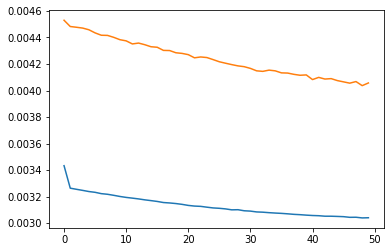

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(train_loss, label='train')
ax.plot(valid_loss, label='valid')
fig.show()

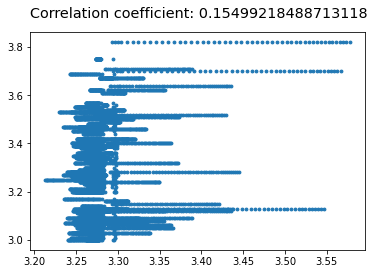

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

# 標準化・正規化を戻す
ss = full_dataset.ss_score
ms = full_dataset.ms_score
plot_outputs = ss.inverse_transform(ms.inverse_transform(valid_outputs.cpu().detach().numpy()))
plot_scores = ss.inverse_transform(ms.inverse_transform(valid_scores.cpu().detach().numpy()))

from itertools import chain
# 相関行列を計算
coef = np.corrcoef(list(chain.from_iterable(plot_outputs)), list(chain.from_iterable(plot_scores)))
# print(plot_outputs)
# fig内でのaxes座標を取得，戻り値はBbox
ax_pos = ax.get_position()
coef_text = "Correlation coefficient: " + str(coef[0][1])
# fig内座標でテキストを表示 Bboxは Bbox.x0, Bbox.x1, Bbox.y0, Bbox.y1で座標を取得できる
fig.text(ax_pos.x0, ax_pos.y1 + 0.05, coef_text, fontsize='x-large')  

ax.scatter(plot_outputs, plot_scores, s=8)
fig.show()

In [ ]:
print("各特徴量ごとの平均値は"+str(ms.mean_))
print("各特徴量ごとの標準偏差は"+str(ms.var_))

- 重みは更新しない（->p.requires_grad=False）
- 回帰問題にするために、out_features=1に設定
- dataloaderのときにNormalizeを変更、画像サイズも調整 -> h:224, w:224